In [1]:
plotsize = function (x,y) options(repr.plot.width=x, repr.plot.height=y)

In [2]:
library(foreach)
library(doFuture)
library(causalLearning)
library(itecv)
library(magrittr)
library(tidyverse)
library(zeallot)
library(xtable)

registerDoFuture()
plan(cluster, workers = 4)

Loading required package: future
Loading required package: iterators
Loading required package: parallel
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ tidyr::extract()    masks magrittr::extract()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::set_names()  masks magrittr::set_names()
✖ purrr::when()       masks foreach::when()

Attaching package: ‘zeallot’

The following objects are masked from ‘package:future’:

    %->%, %<-%



In [3]:
# From Scott's utils.R:
stratify = function(prop.score, treatment, min.per.arm = 30) {
# prop.score:   vector of propensity scores
# treatment:    vector of treatment indicators
# min.per.arm:  minimum number of observations for each arm within each stratum

  stratum = ceiling(10 * prop.score)
  cutoffs = sort(unique(stratum/10))
  stratum = as.numeric(as.factor(stratum))

  num.treated = aggregate(treatment, list(stratum = stratum), sum)$x
  while(min(num.treated) < min.per.arm & length(unique(stratum)) > 1) {
    stratum1 = which.min(num.treated)
    cutoffs = cutoffs[-which.min(num.treated)]
    neighbors = intersect(stratum, stratum1 + c(-1, 1))
    stratum2 = neighbors[which.min(num.treated[neighbors])]
    stratum[stratum == stratum1] = stratum2
    stratum = as.numeric(as.factor(stratum))
    num.treated = aggregate(treatment, list(stratum = stratum), sum)$x
  }

  stratum = 1 + max(stratum) - stratum
  cutoffs = rev(cutoffs)

  num.control = aggregate(1 - treatment, list(stratum = stratum), sum)$x
  while(min(num.control) < min.per.arm & length(unique(stratum)) > 1) {
    stratum1 = which.min(num.control)
    cutoffs = cutoffs[-which.min(num.control)]
    neighbors = intersect(stratum, stratum1 + c(-1, 1))
    stratum2 = neighbors[which.min(num.control[neighbors])]
    stratum[stratum == stratum1] = stratum2
    stratum = as.numeric(as.factor(stratum))
    num.control = aggregate(treatment, list(stratum = stratum), sum)$x
  }

  cutoffs[1] = 1
  cutoffs = rev(cutoffs)

  list(stratum = 1 + max(stratum) - stratum, cutoffs = cutoffs)
}

In [47]:
p_model_specs = list(
    ranger = list(
        tune_grid = expand.grid(
            mtry = 3, 
            splitrule = "gini", 
            min.node.size = 5),
        extra_args = list(
            num.trees=500))
)

m_model_specs = list(
    gbm = list(
        tune_grid = expand.grid(
            n.trees = seq(1,501,10), 
            interaction.depth=2, 
            shrinkage = 0.01, 
            n.minobsinnode=5),
        extra_args = list(
            verbose=F, 
            bag.fraction=0.5))
)

tau_model_specs = list(
    gbm = list(
        tune_grid = expand.grid(
            n.trees = seq(1,501,10), 
            interaction.depth=2, 
            shrinkage = 0.01, 
            n.minobsinnode=5),
        extra_args = list(
            verbose=F, 
            bag.fraction=0.5))
)

#     glmnet = list(
#         tune_grid = expand.grid(
#             alpha=c(0,0.5,1),
#             lambda=exp(seq(-5,2,0.4))),
#         extra_args = list())

In [61]:
DGPs = powers_DGPs() %>% list(1:16) %>% 
    pmap(function(dgp, id) {
        dgp$id = id
        dgp
    })
c(itrain, ival, itest) %<-% make_indices(1000, 1000, 1000)

In [62]:
run_sim = function(replicate, DGP, p_model_specs, m_model_specs, tau_model_specs, itrain, ival, itest) {
    # Generate the data from the simulation data-generating process (DGP)
#     c(x,w,y,p,mu0,mu1,tau) %<-% create_data(DGP, length(c(itrain, ival, itest)))
    d = create_data(DGP, length(c(itrain, ival, itest)))
    x = d$x
    w = d$w
    y = d$y
    p = d$p
    tau = d$tau
    
    # Fit propensity if necessary
    if (DGP$randomized) {
        p_hat = cross_validated_cross_estimation(
            x[itrain,], w[itrain], 
            p_model_specs,  
            k_folds_cv=5, 
            k_folds_ce=5)
    } else {
        p_hat = p[itrain]
    }
    
    # Fit the R-learner
    m_hat = cross_validated_cross_estimation(
        x[itrain,], y[itrain], 
        m_model_specs, 
        k_folds_cv=5, 
        k_folds_ce=5)
    
    r_model = learner_cv(
        x[itrain,], (y[itrain]-m_hat)/(w[itrain]-p_hat), 
        tau_model_specs, 
        weights=(w[itrain]-p_hat)^2,
        k_folds=5) 
    
    # Fit the causal boosting model
    if (DGP$randomized) {
        cb_model = cv.causalBoosting(x[itrain,], as.numeric(w[itrain]), y[itrain])
    } else {
        stratum = stratify(p_hat, w[itrain])$stratum
        cb_model = cv.causalBoosting(x[itrain,], as.numeric(w[itrain]), y[itrain], propensity=T, stratum=stratum)
    }
    
    # Get predictions from both models
    tauhat_r_te = predict(r_model, newdata=x[-itrain,])
    tauhat_cb_te = predict(cb_model, x[-itrain,])
    
    data.frame(
        cb=tauhat_cb_te, 
        rlearn=tauhat_r_te, 
        tau=tau[-itrain], 
        dgp=DGP$id, 
        replicate=replicate)
}

In [55]:
result = run_sim(1, DGPs[[13]], p_model_specs, m_model_specs, tau_model_specs, itrain, ival, itest)

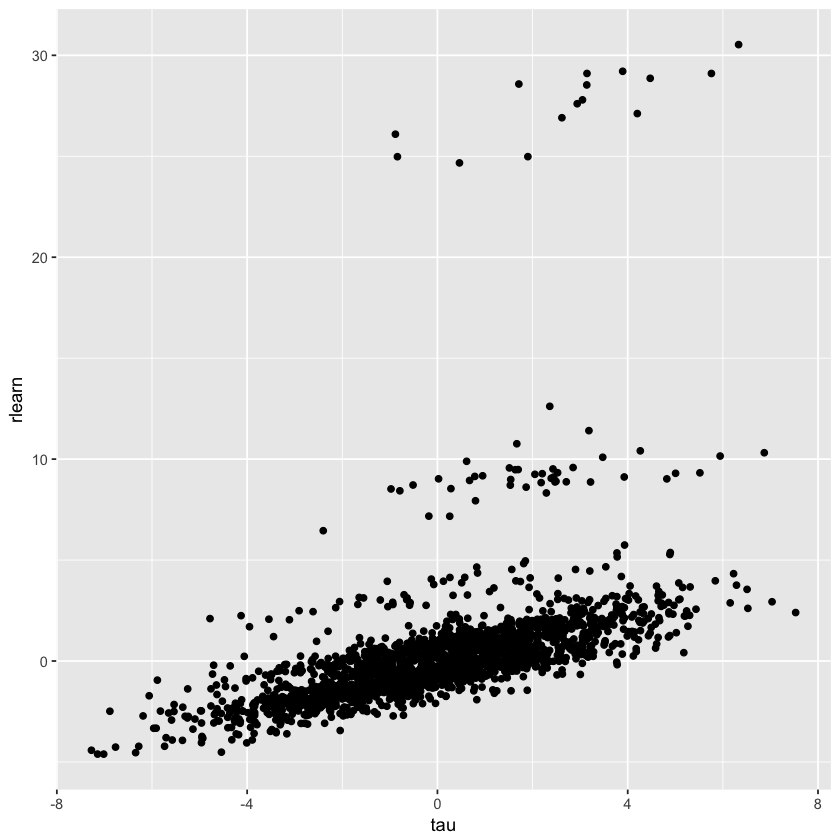

In [57]:
result %$% qplot(tau, rlearn)

In [ ]:
foreach(DGP = DGPs, 
        .export=c(
            "p_model_specs", "m_model_specs", "tau_model_specs",
            "itrain", "ival", "itest", "run_sim"),
        .combine = bind_rows,
        .packages = (.packages())) %:%
    foreach(replicate = 1:5, 
            .export=c(
                "p_model_specs", "m_model_specs", "tau_model_specs",
                "itrain", "ival", "itest", "run_sim"),
            .combine = bind_rows,
            .packages = (.packages()))  %dopar%  {
        run_sim(replicate, DGP, p_model_specs, m_model_specs, tau_model_specs, itrain, ival, itest) 
    } %>% write_csv("data/rob_test.csv")

In [ ]:
result = read_csv("data/rob_test.csv", col_types="dddii")

In [ ]:
proc_res = result %>%
    gather(learner, tauhat, -dgp, -replicate, -tau) 

In [ ]:
plotsize(10,15)
proc_res %>%
ggplot(aes(x=tau, y=tauhat, color=learner)) + 
    geom_point(size=0.3, alpha=0.2) +
    geom_abline(slope=1) +
    facet_grid(dgp ~ replicate, scales="free")

In [ ]:
proc_res %>% 
    group_by(dgp, learner, replicate) %>%
    summarize(tauMSE = mse(tauhat, tau)) %>%
    ungroup() %>% group_by(dgp, learner) %>%
    summarize(mean_tauMSE = mean(tauMSE), sd_mean_tauMSE=sd(tauMSE)/sqrt(n())) %>%
    ungroup() %>% group_by(dgp) %>%
    mutate(fig = ifelse(mean_tauMSE == min(mean_tauMSE), 
                        sprintf("\\bfseries{%0.3f} $\\pm$ %0.2f", mean_tauMSE, 2*sd_mean_tauMSE),
                        sprintf("%0.3f $\\pm$ %0.2f", mean_tauMSE, 2*sd_mean_tauMSE))) %>%
    select(dgp, learner, fig) %>%
    ungroup %>% spread(learner, fig)  %>%
    xtable %>% 
    print.xtable(
        type="latex", 
        sanitize.text.function = function(x) x,
        include.rownames=FALSE)